In [388]:

## Notes on Hyperparameter Tuning, Batch Normalization and Programming Frameworks 
# (week 3 of course 2 in deep learning specialisation)


# to improve: use softmax to predict plant species, batch norm, hyperparam search
# at present: have softmax implemented BUT the weights all come out as NaN: think the dimensions of 
# some values aren't squaring up



## Aiming to predict which species a plant is

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import tensorflow as tf

In [345]:
### hyperparams, his take on what are most important
# learning rate is most important hyperparam to get right
# 2nd in importance: no. of nodes in layers, beta, mini-batch size
# 3rd: learning rate decay, number of layers
# less important: beta1, beta2, epsilon (all the ones used in Adam optimisation)

# though IRL it can be hard to know in advance which hyperparams will most impact your particular NN

# when selecting samples for tuning: better to have some randomness in all dimensions of possible hyperparams,
# not a grid. As if one dimension (ie one hyperparam) turns out to be way more important than the others, you 
# will have a good variety of values tried


# 'Coarse to fine' approach: sampling broadly in possible hyperparam space, then zooming and sampling from smaller
# area which is returning most promising values


# 



In [389]:
#### Batch normalisation
# normalising the inputs for each layer (not just the input array X)
# 
# 
# batch norm is applied after linear transformation but before the activation function
# 

# as batch norm changes the mean to be zero, the B term in WX + B becomes irrelevant, so if
# using batch norm you can stop using B, and just search for weights to multiply the input array by
# In practice the beta input to tilda_norm_layer_output ends up doing a very similar job, as it 
# sets the mean: so this is trained in gradience descent instead (as is gamma)


def norm_layer_output(z_output):
    epsilon = 10**-8   # tiny number to ensure denominator is never exactly zero
    
    mu = np.mean(z_output)
    sigma_squared = np.var(z_output)
    return (z_output - mu) / np.sqrt(sigma_squared + epsilon)


# the above sets variance to one and mean to zero for hidden layer output, and in 
# some cases that won't be what you want




def tilda_norm_layer_output(normed_z_output, gamma, beta):
    """Takes result of norm_layer_output() as an input
    gamma rescales the variance of the data
    beta changes the mean of the data
    
    gamma dims = n[l] * 1   # eg: if a layer has 5 nodes, this will have dimensions 5*1
    beta dims = n[l] * 1
    
    optimal gamma and beta values can be learned as part of gradient descent process: do this
    by treating them as another few weights to learn within that layer
    
    note beta in this context is quite separate to beta in other contexts, eg: Adam optimising
    """
    return (gamma * normed_z_output) + beta




# for the formula:
# https://www.coursera.org/learn/deep-neural-network/lecture/4ptp2/normalizing-activations-in-a-network


# batch norm reduces the amount later layers have to adapt to changes (of weights) in earlier layers
# thus speeds training
# 
# similar to dropout, mini-batch and batch norming adds a little noise, as training on only a sample of 
# the full training set
# I think batch norming is in the same bucket as mini-batch on this because it adds extra weights to 
# train, which means more influence/noise from a given training iteration

# Says this regularisation effect is fairly small, and more of a side effect than something you can count on

# Noise forces later layers not to overfit to earlier layer output



In [350]:
### applying model to batch norm:
# might only want to put one data thru it, so can't normalise by variance of sample
# so estimate the best mu and variance values using training set prior to applying model

# this is done with exponential weighted average across the mu and variance values
# for mini-batches on the final epoch (or I think it's the final epoch: not much gains to using older epochs)

# 



In [390]:
## Multiple classes: softmax regression

# output layer has count of nodes equal to number of classes (classification options)

# each node in output layer outputs probability that the data is of the class that node represents

# the total probabilities should sum to one (denominator in function below does this)

def softmax_activation(input_array):
    """data still needs to go through linear transform before applying this activation func"""
    return np.exp(input_array) / np.sum(np.exp(input_array))


# if no. of classes=2, softmax is same as logistic activation
# softmax is a generalisation of logistic activation to N classes



# for softmax:
# https://www.coursera.org/learn/deep-neural-network/lecture/HRy7y/softmax-regression

In [391]:

def softmax_single_data_point_loss(predicted_single_data, actual_single_data):
    """Both inputs are n*1 arrays, where n is number of classes
    
    Not used as it's easier to implement this inside the softmax_cost function below
    """
    return -np.sum(actual * np.log(predicted)) 


def softmax_cost(predicted, actual):
    """Aggregates losses across full batch
    
    The course video shows two separate functions: one for each data and one summing all results, 
    however it seems easier to do them both in one line
    
    "actual" should be 1s and 0s
    """
    m = predicted.shape[0]
    
    all_data_loss = -np.sum(actual * np.log(predicted)) / m  # sum across columns
    
    return all_data_loss


def derivative_cost_wrt_softmax(predicted, actual):
    """Same as for logistic function"""
    return predicted - actual



# for softmax loss func:
# https://www.coursera.org/learn/deep-neural-network/lecture/LCsCH/training-a-softmax-classifier

In [352]:
## for regression NN (my ideas)
# use a regression cost function eg sum of squared errors
# otherwise keep everything the same... it might work
# output layer could have multiple dimensions (eg: if you're trying to predict 2+ numbers for each data), the
        # sum of which vs actual values could feed the cost function
    


In [392]:
w = tf.Variable(0, dtype=tf.float32)
optimiser = tf.keras.optimizers.Adam(0.1)

def train_step():
    """single step towards minimising cost function (quadratic in this case)"""
    with tf.GradientTape() as tape:   # idea is it's a "tape" you play forward, and then rewind the tape as backprop
        cost = w**2 + 10*w + 25
    trainable_variables = [w]   # list of variable names - only one in this case
    grads = tape.gradient(cost, trainable_variables)
    optimiser.apply_gradients(zip(grads, trainable_variables))  #zip() pairs corresponding elements in inputs


print('initial value of w: ' + str(w))     
train_step()
print('new value of w: ' + str(w))   
    

initial value of w: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
new value of w: <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.09999997>


In [378]:
for i in range(1000):
    train_step()
    
print(w)   # converges on value that minimises cost func: 5

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-5.000001>


In [ ]:
# only have to write forward propagation stage in tensorflow: it deals with the backprop for you

In [ ]:
# so in tensorflow you just define the cost function, nn structures, optimiser, and maybe a few
# other things, and you're golden


# tensorflow automatically calculates the derivative of your cost function and all subsequent derivatives


In [ ]:
# tensorflow is available in c++, but it's pretty damn optimised in python already


In [393]:
### Activation functions:
# denote generic activation function as g(x)

# sigmoid
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(sigmoid_output):
    return sigmoid_output * (1- sigmoid_output)   # * = element-wise mult; @ = matrix mult


# ReLu: better for larger values as the gradient doesn't become close to 0, which it does for tanh and sigmoid
# ReLu trains faster because of this 
def relu(x):
    return np.where(x >= 0, x, 0)

def relu_derivative(x):       
    """note x is the original input to relu, not the output from relu, unlike other
    derivatives of activation functions"""
    return np.where(x >= 0, 1, 0)




In [423]:
# load data
data = pd.read_csv('https://gist.githubusercontent.com/curran/a08a1080b88344b0c8a7/raw/0e7a9b0a5d22642a06d3d5b9bcbad9890c8ee534/iris.csv')
data = data.to_numpy()



# randomising order for test/train split
idx = np.random.rand(*data.shape).argsort(axis=0) 
data = np.take_along_axis(data,idx,axis=0)




# dummy code labels (3 by 150 dimensions - for logistic activation it was 1d, now 2d)
setosa_idx = data[:, 4] == 'setosa' 
virginica_idx = data[:, 4] == 'virginica' 
versicolor_idx = data[:, 4] == 'versicolor' 
labels_dummy = np.concatenate((setosa_idx, virginica_idx, versicolor_idx)).reshape(3, 150).astype(np.float32)


# normalise first 4 columns
for i in range(4): 
    norms_each_column = np.linalg.norm(data[:, i], axis = 0)
    data[:, i] = data[:, i] / norms_each_column

    

    
# split into train and test
train_input = data[:120, :4].T   # transpose to row for each feature and column for each value: faster calcs
test_input = data[120:, :4].T

train_labs = labels_dummy[:, :120]
test_labs = labels_dummy[:, 120:]



In [395]:
def feedforward_relu_layer(X, W, B):
    """
    X = input data 
    W = input weights
    B = input bias
    
    Exports Z as it's needed for backpropagation
    """
    Z = np.dot(W, X) + B
    return relu(Z), Z  # returns 2 n * m arrays  (n = number of neurons)


def backpropagate_relu_layer(X, Z, dZ_nextLayer, W_nextLayer):
    """
    X = input at start of the layer (from input layer or previous hidden layer)
    Z = values after X been through linear calculation (yx + b)
    dZ_nextLayer = dZ from layer next-closest to output layer
    W_nextLayer = W from layer next-closest to output layer
    """
    m = X.shape[1]                                 # total input data in training set
    dZ_thisLayer = (W_nextLayer.T @ dZ_nextLayer) * relu_derivative(Z)  
    dW_this_layer = (1/m) * (dZ_thisLayer @ X.T)
    dB_this_layer = (1/m) * np.sum(dZ_thisLayer, axis=1, keepdims=True)
    return dZ_thisLayer, dW_this_layer, dB_this_layer

In [396]:
def cost_function(y, y_hat):   
    """Logistic regression cost function
    y = actual
    y_hat = predicted
    """
    m = y.shape[1]  # total predictions made
    lhs = np.dot(y, np.log(y_hat).T) # returns 1x1 array
    rhs = np.dot((1 - y), np.log(1 - y_hat).T)
    total_loss = np.sum(lhs + rhs)
    return -total_loss / m

In [397]:
def update_adam_parameters(v_dw, v_db, s_dw, s_db, dW, dB, beta1, beta2):
    v_dw_new = beta1 * v_dw + (1-beta1) * dW    # same formula as momentum
    v_db_new = beta1 * v_db + (1-beta1) * dB
    s_dw_new = beta2 * s_dw + (1-beta2) * np.power(dW, 2)   # same formula as RMSprop
    s_db_new = beta2 * s_db + (1-beta2) * np.power(dB, 2)
        
    v_dw_new = v_dw_new.astype(float)
    v_db_new = v_db_new.astype(float)
    s_dw_new = s_dw_new.astype(float)
    s_db_new = s_db_new.astype(float)
    return v_dw_new, v_db_new, s_dw_new, s_db_new

In [471]:
def gradient_descent(X, Y, n_layer, lr_init, iterations, decay_rate, beta1=0.9, beta2=0.999):
    """
    Trains parameters for NN with 3 hidden layers, and output layer with sigmoid activation
    
    X = input table (n * m)
    Y = labels    (1 * m)
    lr = Learning rate: how much weights change on each iteration
   """
    
    loss_store = np.zeros(iterations)  # to store loss on each iteration
    
    epsilon = 10**-8  # used in Adam optimiser
    
    
    # set dimension values used 
    n_0 = X.shape[0]   # total features 
    n_1 = n_layer         # number of neurons in hidden layer
    n_2 = 3         # output units: 1 if sigmoid output activation, more if softmax
    

    m = X.shape[1]   # size of input data
    
    # initialise weights             
    W_1_1 = np.random.randn(n_1, n_0) * np.sqrt(2 / n_0)  # notice weights in first layer have different dims
    W_1_2 = np.random.randn(n_1, n_1) * np.sqrt(2 / n_1) 
    W_1_3 = np.random.randn(n_1, n_1) * np.sqrt(2 / n_1) 
    B_1_1 = np.random.randn(n_1, 1) * np.sqrt(2 / n_1) 
    B_1_2 = np.random.randn(n_1, 1) * np.sqrt(2 / n_1) 
    B_1_3 = np.random.randn(n_1, 1) * np.sqrt(2 / n_1) 
    
    W_2 = np.random.randn(n_2, n_1) * np.sqrt(2 / n_1) 
    B_2 = np.random.randn(n_2, 1) * np.sqrt(2 / n_1) 

    
    # group training data for mini-batch
    mini_batch_groups = np.split(X, 6, axis = 1)
    mini_batch_group_labels = np.split(Y, 6, axis = 1)
    
    
    # initialise values for Adam optimiser
    v_dw_1_1 = 0.0
    s_dw_1_1 = 0.0
    v_db_1_1 = 0.0
    s_db_1_1 = 0.0
    
    v_dw_1_2 = 0.0
    s_dw_1_2 = 0.0
    v_db_1_2 = 0.0
    s_db_1_2 = 0.0
    
    v_dw_1_3 = 0.0
    s_dw_1_3 = 0.0
    v_db_1_3 = 0.0
    s_db_1_3 = 0.0
    
    v_dw_2 = 0.0
    s_dw_2 = 0.0
    v_db_2 = 0.0
    s_db_2 = 0.0


    
    #### starting gradient descent loop
    start_time = time.time()
    epoch_number = 1
    for i in range(iterations):
        
        
        # selecting mini batch data for this iter
        group_selected = np.mod(i, 6)
        X = mini_batch_groups[group_selected]
        Y = mini_batch_group_labels[group_selected]
        if group_selected == 0:
            epoch_number += 1
            #print('end of epoch ' + str(i / 6))
        
        
        
        # hidden layer: compute linear transformation of inputs
        A_1_1, Z_1_1 = feedforward_relu_layer(X, W_1_1, B_1_1)
        A_1_2, Z_1_2 = feedforward_relu_layer(A_1_1, W_1_2, B_1_2)
        A_1_3, Z_1_3 = feedforward_relu_layer(A_1_2, W_1_3, B_1_3)


        # output layer: linear transformation and activation func
        Z_2 = np.dot(W_2, A_1_3) + B_2
        Z_2 = Z_2.astype(np.float) # ensure is float; needed for sigmoid() to work
        A_2 = softmax_activation(Z_2)
        
                
        # store cost
        m = A_2.shape[0] * A_2.shape[1]
        #print(A_2[:4, :4])
        loss_store[i] = -np.sum(Y * np.log(A_2)) / m  
    


        # output layer: get derivatives
        dZ_2 = A_2 - Y   
        print(dZ_2.shape)
        dZ_2_temp = np.sum(dZ_2, axis = 0).reshape(1, 20)
        print(dZ_2.shape)
        dW_2 = (1/m) * (dZ_2_temp @ A_1_3.T)   #### issue is here: dims of dZ_2 =3,20; dims of A_1_3=10,20
                                            ### however fudging this by creating dZ_2_temp doesnt help much
                                            ### so something else is occuring
                
                                            ### weights are pushed towards zero, leading to what looks like
                                            ### underflow: not clear on the cause
        dB_2 = (1/m) * np.sum(dZ_2, axis=1, keepdims=True)  # sums horizontally
        
        print(dB_2.shape)

        
        
        # hidden layers: get derivatives 
        dZ_1_3, dW_1_3, dB_1_3 = backpropagate_relu_layer(A_1_2, Z_1_3, dZ_2, W_2)
        dZ_1_2, dW_1_2, dB_1_2 = backpropagate_relu_layer(A_1_1, Z_1_2, dZ_1_3, W_1_3)
        dZ_1_1, dW_1_1, dB_1_1 = backpropagate_relu_layer(X, Z_1_1, dZ_1_2, W_1_2)

        
        # calculate decaying learning rate
        lr = learning_rate_decay(lr_init, decay_rate, epoch_number)
        
        
        # Updating Adam opimiser parameters
        v_dw_1_1,v_db_1_1,s_dw_1_1, s_db_1_1 = update_adam_parameters(v_dw_1_1, v_db_1_1, s_dw_1_1, s_db_1_1, dW_1_1, dB_1_1, beta1, beta2)
        v_dw_1_2,v_db_1_2,s_dw_1_2, s_db_1_2 = update_adam_parameters(v_dw_1_2, v_db_1_2, s_dw_1_2, s_db_1_2, dW_1_2, dB_1_2, beta1, beta2)
        v_dw_1_3,v_db_1_3,s_dw_1_3, s_db_1_3 = update_adam_parameters(v_dw_1_3, v_db_1_3, s_dw_1_3, s_db_1_3, dW_1_3, dB_1_3, beta1, beta2)
        v_dw_2,v_db_2,s_dw_2, s_db_2 = update_adam_parameters(v_dw_2, v_db_2, s_dw_2, s_db_2, dW_2, dB_2, beta1, beta2)

                                                                
         # leaving out 'bias correcting' v_dw and others, where t = total iterations so far
        # v_dw = v_dw / (1 - beta^t)  
        # v_db = v_db / (1 - beta^t)  
        # s_dw = s_dw / (1 - beta2^t)
        # s_db = s_db / (1 - beta2^t)

        

        # update weights using Adam optimiser scaling
        """
        print('s_dw_1_1: ' + str(s_dw_1_1))
        print('epsilon: ' + str(epsilon))
        print('epsilon: ' + str(epsilon + s_dw_1_1))
        print('np.sqrt(s_dw_1_1 + epsilon)')
        print(type(s_dw_1_1))
        print((s_dw_1_1.shape))
        """
        """
        print('B_1_1 dim earlier: ' + str(B_1_1.shape))
        print('v_db_1_1 dim earlier: ' + str(v_db_1_1.shape))
        print('s_db_1_1 dim earlier: ' + str(s_db_1_1.shape))
        """
        
        W_1_1 = W_1_1 - (lr * v_dw_1_1) / np.sqrt(s_dw_1_1 + epsilon)
        B_1_1 = B_1_1 - (lr * v_db_1_1) / np.sqrt(s_db_1_1 + epsilon)
        
        W_1_2 = W_1_2 - (lr * v_dw_1_2) / np.sqrt(s_dw_1_2 + epsilon)
        B_1_2 = B_1_2 - (lr * v_db_1_2) / np.sqrt(s_db_1_2 + epsilon)
        
        W_1_3 = W_1_3 - (lr * v_dw_1_3) / np.sqrt(s_dw_1_3 + epsilon)
        B_1_3 = B_1_3 - (lr * v_db_1_3) / np.sqrt(s_db_1_3 + epsilon)
        
        W_2 = W_2 - (lr * v_dw_2) / np.sqrt(s_dw_2 + epsilon)
        B_2 = B_2 - (lr * v_db_2) / np.sqrt(s_db_2 + epsilon)
                
        if (np.mod(i, 1000) == 0):
            print('iteration done: ' + str(i))

            """
        W_1_1 = W_1_1 - lr * dW_1_1
        W_1_2 = W_1_2 - lr * dW_1_2
        W_1_3 = W_1_3 - lr * dW_1_3
        B_1_1 = B_1_1 - lr * dB_1_1
        B_1_2 = B_1_2 - lr * dB_1_2
        B_1_3 = B_1_3 - lr * dB_1_3
        W_2 = W_2 - lr * dW_2
        B_2 = B_2 - lr * dB_2
        """
        
    
    avg_iter_time = (time.time() - start_time) / iterations

    return W_1_1, W_1_2, W_1_3, B_1_1,B_1_2, B_1_3, W_2, B_2, loss_store, avg_iter_time

    


In [472]:
## training model weights. n_layer represents the number of nodes in each layer
W_1_1, W_1_2, W_1_3, B_1_1,B_1_2, B_1_3, W_2, B_2, loss_store, avg_iter_time = gradient_descent(train_input, 
                                                                                                train_labs, 
                                                                                                n_layer = 10, 
                                                                                                lr_init = 0.04, 
                                                                                                iterations = 100, 
                                                                                                decay_rate = 0.02)
print('avg_iter_time: ' + str(avg_iter_time))
# avg_iter_time of 0.005 seconds on full batch
# avg_iter_time of 0.0012 - 0.0019 seconds on 1/6 minibatch
# avg_iter_time of 0.00165 - 0.0032 on minibatch with Adam optimisation

(3, 20)
(3, 20)
(3, 1)
iteration done: 0
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)
(3, 1)
(3, 20)
(3, 20)


<ipython-input-390-90dbb9431a34>:11: RuntimeWarning: overflow encountered in exp
  return np.exp(input_array) / np.sum(np.exp(input_array))
<ipython-input-390-90dbb9431a34>:11: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(input_array) / np.sum(np.exp(input_array))
<ipython-input-471-ec9875a37264>:94: RuntimeWarning: divide by zero encountered in log
  loss_store[i] = -np.sum(Y * np.log(A_2)) / m
<ipython-input-471-ec9875a37264>:94: RuntimeWarning: invalid value encountered in multiply
  loss_store[i] = -np.sum(Y * np.log(A_2)) / m


In [474]:
print(W_2)
print(loss_store)


# making labels in format for plot
plot_y_vals = []
for i in range(30):
    if test_labs[0][i] == 1:
        plot_y_vals.append(0)
    if test_labs[1][i] == 1:
        plot_y_vals.append(1)
    if test_labs[2][i] == 1:
        plot_y_vals.append(2)
        

#plt.plot([ 1.49508955 , 1.40739113  ,1.62602013,  2.16057992,  3.25374524,  4.95413588,12.07336694, 14.4747404,  32.348698])

[[nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]]
[ 1.35379959  1.35845545  1.40075824  1.4853439   1.65642324  2.17004114
  3.96865145  4.5863341   9.24327137 14.76260796         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan       

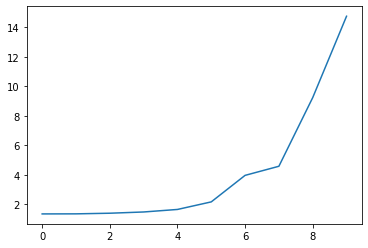

In [475]:
# viewing trend in loss
plt.plot(loss_store)



[[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
  nan nan nan nan nan nan nan nan nan nan nan nan]]


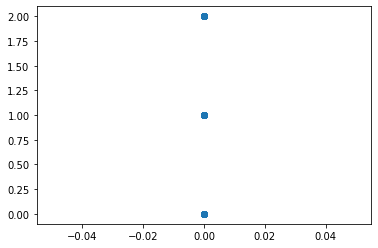

In [476]:
# applying to test set (Z matrices are created but not used)
A_1_1, Z_1_1 = feedforward_relu_layer(test_input, W_1_1, B_1_1)
A_1_2, Z_1_2 = feedforward_relu_layer(A_1_1, W_1_2, B_1_2)
A_1_3, Z_1_3 = feedforward_relu_layer(A_1_2, W_1_3, B_1_3)
Z_2 = np.dot(W_2, A_1_3) + B_2
print(Z_2)
Z_2 = Z_2.astype(np.float) # ensure is float
predictions = softmax_activation(Z_2)



#### plotting predictions vs actual for the three classes
plot_predictions = []
for i in range(30):
    val = np.argmax([predictions[0][i], predictions[1][i], predictions[2][i]])
    plot_predictions.append(val)

plt.scatter(plot_predictions, plot_y_vals)
plt.show()